# Example for life cycle assessment module of AeroMAPS


## Load modules

First, the user has to load the framework and generate a process.

In [10]:
%matplotlib widget
import pandas as pd
from aeromaps import create_process
from aeromaps.core.models import (
    models_traffic,
    models_efficiency_bottom_up,
    models_energy_without_fuel_effect,
    models_offset,
    models_climate_simple_gwpstar,
    models_sustainability,
)
from aeromaps.models.air_transport.aircraft_fleet_and_operations.fleet.fleet_numeric import (
    FleetEvolution,
)
from aeromaps.models.impacts.life_cycle_assessment.life_cycle_assessment import LifeCycleAssessment
from aeromaps.models.air_transport.aircraft_fleet_and_operations.fleet.fleet_model import (
    # Fleet,
    AircraftParameters,
    Aircraft,
)
import brightway2 as bw
import lca_algebraic as agb
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import math
import collections
import time

plt.style.use("bmh")

In [11]:
start_time = time.time()
extended_models = {
    "models_traffic": models_traffic,
    "models_efficiency_bottom_up": models_efficiency_bottom_up,
    "models_energy_without_fuel_effect": models_energy_without_fuel_effect,
    "models_offset": models_offset,
    "models_climate_simple_gwpstar": models_climate_simple_gwpstar,
    "models_sustainability": models_sustainability,
    "fleet_numeric": FleetEvolution("fleet_numeric"),
    "life_cycle_assessment": LifeCycleAssessment(
        "life_cycle_assessment",
        reset=False,  # set to True to reset brightway project (including ecoinvent and premise)
    ),
}
print("--- %s seconds ---" % (time.time() - start_time))
bw.databases

Initial setup of EcoInvent already done, skipping. To reset the project use option `reset=True`.
Building LCA model from configuration file... Done.
Parametrizing LCIA impacts... Done.
--- 179.48519921302795 seconds ---


Databases dictionary with 23 objects, including:
	Foreground DB
	biosphere3
	ecoinvent-3.9.1-cutoff
	ecoinvent_cutoff_3.9_image_SSP2-Base_2020
	ecoinvent_cutoff_3.9_image_SSP2-Base_2030
	ecoinvent_cutoff_3.9_image_SSP2-Base_2040
	ecoinvent_cutoff_3.9_image_SSP2-Base_2050
	ecoinvent_cutoff_3.9_image_SSP2-RCP26_2020
	ecoinvent_cutoff_3.9_image_SSP2-RCP26_2030
	ecoinvent_cutoff_3.9_image_SSP2-RCP26_2040
Use `list(this object)` to get the complete list.

## Aircraft fleet

In [12]:
# Aircraft fleet


def set_aircraft_fleet(process):
    ## Initialization
    fleet = process.fleet

    ## Short Range
    short_range_aircraft_params = AircraftParameters(
        entry_into_service_year=2035,
        consumption_evolution=-20.0,
        nox_evolution=0.0,
        soot_evolution=0.0,
        doc_non_energy_evolution=0.0,
        cruise_altitude=12000.0,
        ask_year=280000000,
        rc_cost=50000000,
        nrc_cost=10000000000.0,
    )
    short_range_aircraft = Aircraft(
        "New Short-range Aircraft",
        parameters=short_range_aircraft_params,
        energy_type="DROP_IN_FUEL",
    )
    fleet.categories["Short Range"].subcategories[0].add_aircraft(aircraft=short_range_aircraft)

    ## Medium Range
    medium_range_aircraft_params = AircraftParameters(
        entry_into_service_year=2035,
        consumption_evolution=-20.0,
        nox_evolution=0.0,
        soot_evolution=0.0,
        doc_non_energy_evolution=0.0,
        cruise_altitude=12000.0,
        ask_year=352000000.0,
        rc_cost=60000000.0,
        nrc_cost=10000000000.0,
    )
    medium_range_aircraft = Aircraft(
        "New Medium-range Aircraft",
        parameters=medium_range_aircraft_params,
        energy_type="DROP_IN_FUEL",
    )
    fleet.categories["Medium Range"].subcategories[0].add_aircraft(aircraft=medium_range_aircraft)

    ## Long Range
    long_range_aircraft_params = AircraftParameters(
        entry_into_service_year=2035,
        consumption_evolution=-20.0,
        nox_evolution=0.0,
        soot_evolution=0.0,
        doc_non_energy_evolution=0.0,
        cruise_altitude=12000.0,
        ask_year=912000000.0,
        rc_cost=150000000.0,
        nrc_cost=25000000000.0,
    )
    long_range_aircraft = Aircraft(
        "New Long-range Aircraft", parameters=long_range_aircraft_params, energy_type="DROP_IN_FUEL"
    )
    fleet.categories["Long Range"].subcategories[0].add_aircraft(aircraft=long_range_aircraft)

    ## Fleet renewal
    fleet.categories["Short Range"].parameters.life = 25
    fleet.categories["Medium Range"].parameters.life = 25
    fleet.categories["Long Range"].parameters.life = 25

    process.fleet_model.compute()

    return

## Scenario 1

### a) Set parameters

In [4]:
process = create_process(
    configuration_file="data/data_files/config.json",
    models=extended_models,
    use_fleet_model=True,
    add_examples_aircraft_and_subcategory=False,
)
set_aircraft_fleet(process)
# process.fleet_model.plot()

In [5]:
## Share of alternative fuels in the drop-in fuel mix (the rest being supplemented by kerosene) [%]
process.parameters.biofuel_share_reference_years = [2020, 2025, 2030, 2035, 2040, 2045, 2050]
process.parameters.biofuel_share_reference_years_values = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
process.parameters.electrofuel_share_reference_years = [2020, 2025, 2030, 2035, 2040, 2045, 2050]
process.parameters.electrofuel_share_reference_years_values = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Set water vapor to zero (FIXME?)
process.parameters.emission_index_h2o_kerosene = 0.0
process.parameters.emission_index_h2o_biofuel = 0.0
process.parameters.emission_index_h2o_electrofuel = 0.0

### b) Compute

In [6]:
start_time = time.time()
process.compute()
print("--- %s seconds ---" % (time.time() - start_time))

--- 9.20051383972168 seconds ---


### c) Results and plots

In [7]:
process_data_vector_outputs_scenario_1 = process.data["vector_outputs"]
process_data_fleet_model_df_scenario_1 = process.fleet_model.df
process_data_float_inputs_scenario_1 = process.data["float_inputs"]
lca_outputs_df_scenario_1 = process.lca_outputs_df
lca_outputs_df_scenario_1.T

method acidification: terrestrial - terrestrial acidification potential (TAP)[kg SO2-Eq]  \
phase                                                                            _other_   
2020                                                                                   0   
2021                                                                                   0   
2022                                                                                   0   
2023                                                                                   0   
2024                                                                                   0   
2025                                                                                   0   
2026                                                                                   0   
2027                                                                                   0   
2028                                                                                   0   
2029                                                                                   0   
2030                                                                                   0   
2031                                                                                   0   
2032                                                                                   0   
2033                                                                                   0   
2034                                                                                   0   
2035                                                                                   0   
2036                                                                                   0   
2037                                                                                   0   
2038                                                                                   0   
2039                                                                                   0   
2040                                                                                   0   
2041                                                                                   0   
2042                                                                                   0   
2043                                                                                   0   
2044                                                                                   0   
2045                                                                                   0   
2046                                                                                   0   
2047                                                                                   0   
2048                                                                                   0   
2049                                                                                   0   
2050                                                                                   0   

method                                                     \
phase  aircraft_production     airport combustion_biofuel   
2020                     0  3.8357e+07                  0   
2021           2.19327e+07 5.53719e+07                  0   
2022           2.45146e+07 7.13417e+07                  0   
2023           2.65878e+07 8.62662e+07                  0   
2024            2.7884e+07 1.00146e+08                  0   
2025           3.23301e+07 9.98876e+07                  0   
2026           3.51766e+07  9.9524e+07                  0   
2027           3.53647e+07 9.90488e+07                  0   
2028           3.45709e+07 9.84554e+07                  0   
2029            3.3017e+07 9.77373e+07                  0   
2030           3.09242e+07 9.68875e+07                  0   
2031           2.87225e+07 9.82748e+07                  0   
2032           2.65172e+07  9.9658e+07                  0   
2033           2.44638e+07 1.01036e+08          

In [36]:
def plot_stacked_evolution_subplots(df):
    # Remove phases containing 'sum'
    df_filtered = df[~df.index.get_level_values("phase").str.contains("sum")]

    methods = df_filtered.index.get_level_values("method").unique()  # [:9]
    years = df_filtered.columns

    # Determine the number of rows and columns for the subplots
    n_methods = len(methods)
    n_cols = 3  # 2 if n_methods % 2 == 0 else 3
    n_rows = math.ceil(n_methods / n_cols)

    # Use seaborn color palette for better aesthetics
    palette = sns.color_palette("Set2", len(df_filtered.index.levels[1]))
    # palette = sns.color_palette("Paired", len(df_filtered.index.levels[1]))

    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 4), constrained_layout=False)
    axes = axes.flatten()  # Flatten the array of axes for easy iteration

    for i, method in enumerate(methods):
        df_method = df_filtered.xs(method, level="method")
        # df_method.index = df_method.index.str.replace('_other_', 'Production Electrofuel\n(Fischer-Tropsch process)')

        # Plot stacked area chart with custom colors
        axes[i].stackplot(years, df_method, labels=df_method.index, alpha=0.8, colors=palette)

        # Customize the subplot
        name, unit = method.split("[", 1)
        # name = name.replace('- ', '\n').replace('(', '\n(')
        name = name.replace("total", "")
        name = name.split("- ")[0]
        name = name.replace(":", "\n")
        name = "".join([a if a.isupper() else b for a, b in zip(name, name.title())])
        unit = unit.replace("]", "")
        axes[i].set_title(name, fontsize=12)
        axes[i].set_xlabel("Year")
        axes[i].set_ylabel(unit)
        axes[i].grid(True)
        axes[i].set_axisbelow(True)
        axes[i].ticklabel_format(axis="y", scilimits=(0, 4))

    # Collect legend labels from all plots.
    entries = collections.OrderedDict()
    for ax in axes.flatten():
        for handle, label in zip(*axes[0].get_legend_handles_labels()):
            # if 'biofuel' in label or 'electrofuel' in label:
            #    continue
            label_name = label.replace("_", " ").title()
            entries[label_name] = handle
    legend = fig.legend(
        entries.values(),
        entries.keys(),
        loc="lower center",
        bbox_to_anchor=(0.5, 0),
        ncol=4,
        fontsize=11,
        title="Life-Cycle Phase",
        title_fontsize=12,
    )

    # Set tight layout while keeping legend in the screen
    bbox = legend.get_window_extent(fig.canvas.get_renderer()).transformed(
        fig.transFigure.inverted()
    )
    fig.tight_layout(rect=(0, bbox.y1, 1, 1), h_pad=0.5, w_pad=0.5)

    # show plot
    plt.show()

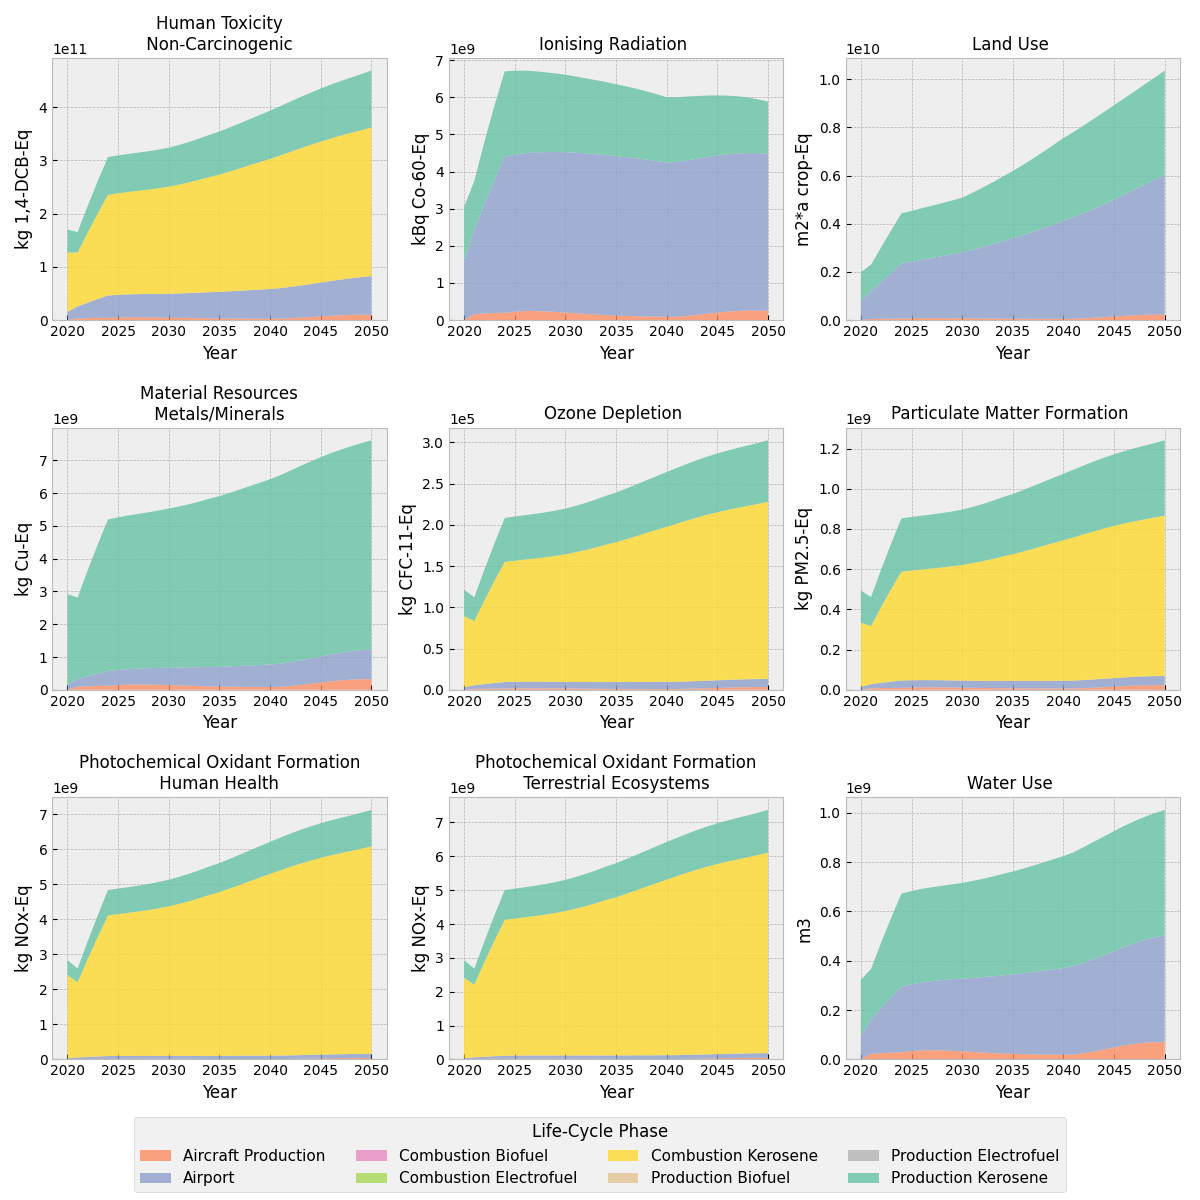

In [17]:
plt.close()

# Call the function
df_to_plot = lca_outputs_df_scenario_1[
    ~lca_outputs_df_scenario_1.index.get_level_values("method").str.contains("total")
]
# df_to_plot = lca_outputs_df_scenario_1[lca_outputs_df_scenario_1.index.get_level_values('method').str.contains('|'.join(['climate', 'land use', 'material']))]
plot_stacked_evolution_subplots(df_to_plot)
plt.savefig("lca_aeromaps_kerosene_midpoints_2.pdf")

## Scenario 2

In [18]:
# Set process
process = create_process(
    configuration_file="data/data_files/config.json",
    models=extended_models,
    use_fleet_model=True,
    add_examples_aircraft_and_subcategory=False,
)
set_aircraft_fleet(process)

## Share of alternative fuels in the drop-in fuel mix (the rest being supplemented by kerosene) [%]
process.parameters.biofuel_share_reference_years = [2020, 2025, 2030, 2035, 2040, 2045, 2050]
process.parameters.biofuel_share_reference_years_values = [0, 2, 4.8, 15, 24, 27, 35]
process.parameters.electrofuel_share_reference_years = [2020, 2025, 2030, 2035, 2040, 2045, 2050]
process.parameters.electrofuel_share_reference_years_values = [0, 0, 1.2, 5, 10, 15, 35]

# Share of photovoltaic in the electricity mix for efuel production
process.parameters.elec_solar_share_reference_years = [2020, 2030, 2040, 2050]
process.parameters.elec_solar_share_reference_years_values = [0.0, 0.0, 0.0, 0.0]

# Set water vapor to zero (FIXME?)
process.parameters.emission_index_h2o_kerosene = 0.0
process.parameters.emission_index_h2o_biofuel = 0.0
process.parameters.emission_index_h2o_electrofuel = 0.0

In [19]:
start_time = time.time()
process.compute()
print("--- %s seconds ---" % (time.time() - start_time))

--- 9.28898310661316 seconds ---


In [20]:
process_data_vector_outputs_scenario_2 = process.data["vector_outputs"]
process_data_fleet_model_df_scenario_2 = process.fleet_model.df
process_data_float_inputs_scenario_2 = process.data["float_inputs"]
lca_outputs_df_scenario_2 = process.lca_outputs_df
lca_outputs_df_scenario_2.T

method acidification: terrestrial - terrestrial acidification potential (TAP)[kg SO2-Eq]  \
phase                                                                            _other_   
2020                                                                                   0   
2021                                                                                   0   
2022                                                                                   0   
2023                                                                                   0   
2024                                                                                   0   
2025                                                                                   0   
2026                                                                                   0   
2027                                                                                   0   
2028                                                                                   0   
2029                                                                                   0   
2030                                                                                   0   
2031                                                                                   0   
2032                                                                                   0   
2033                                                                                   0   
2034                                                                                   0   
2035                                                                                   0   
2036                                                                                   0   
2037                                                                                   0   
2038                                                                                   0   
2039                                                                                   0   
2040                                                                                   0   
2041                                                                                   0   
2042                                                                                   0   
2043                                                                                   0   
2044                                                                                   0   
2045                                                                                   0   
2046                                                                                   0   
2047                                                                                   0   
2048                                                                                   0   
2049                                                                                   0   
2050                                                                                   0   

method                                                     \
phase  aircraft_production     airport combustion_biofuel   
2020                     0  3.8357e+07                  0   
2021           2.19327e+07 5.53719e+07        3.42595e+06   
2022           2.45146e+07 7.13417e+07        8.71058e+06   
2023           2.65878e+07 8.62662e+07        1.55671e+07   
2024            2.7884e+07 1.00146e+08        2.37184e+07   
2025           3.23301e+07 9.98876e+07         2.9097e+07   
2026           3.51766e+07  9.9524e+07        3.42396e+07   
2027           3.53647e+07 9.90488e+07        3.91636e+07   
2028           3.45709e+07 9.84554e+07        4.47046e+07   
2029            3.3017e+07 9.77373e+07        5.58319e+07   
2030           3.09242e+07 9.68875e+07        7.36433e+07   
2031           2.87225e+07 9.82748e+07        9.85136e+07   
2032           2.65172e+07  9.9658e+07        1.30892e+08   
2033           2.44638e+07 1.01036e+08        1.

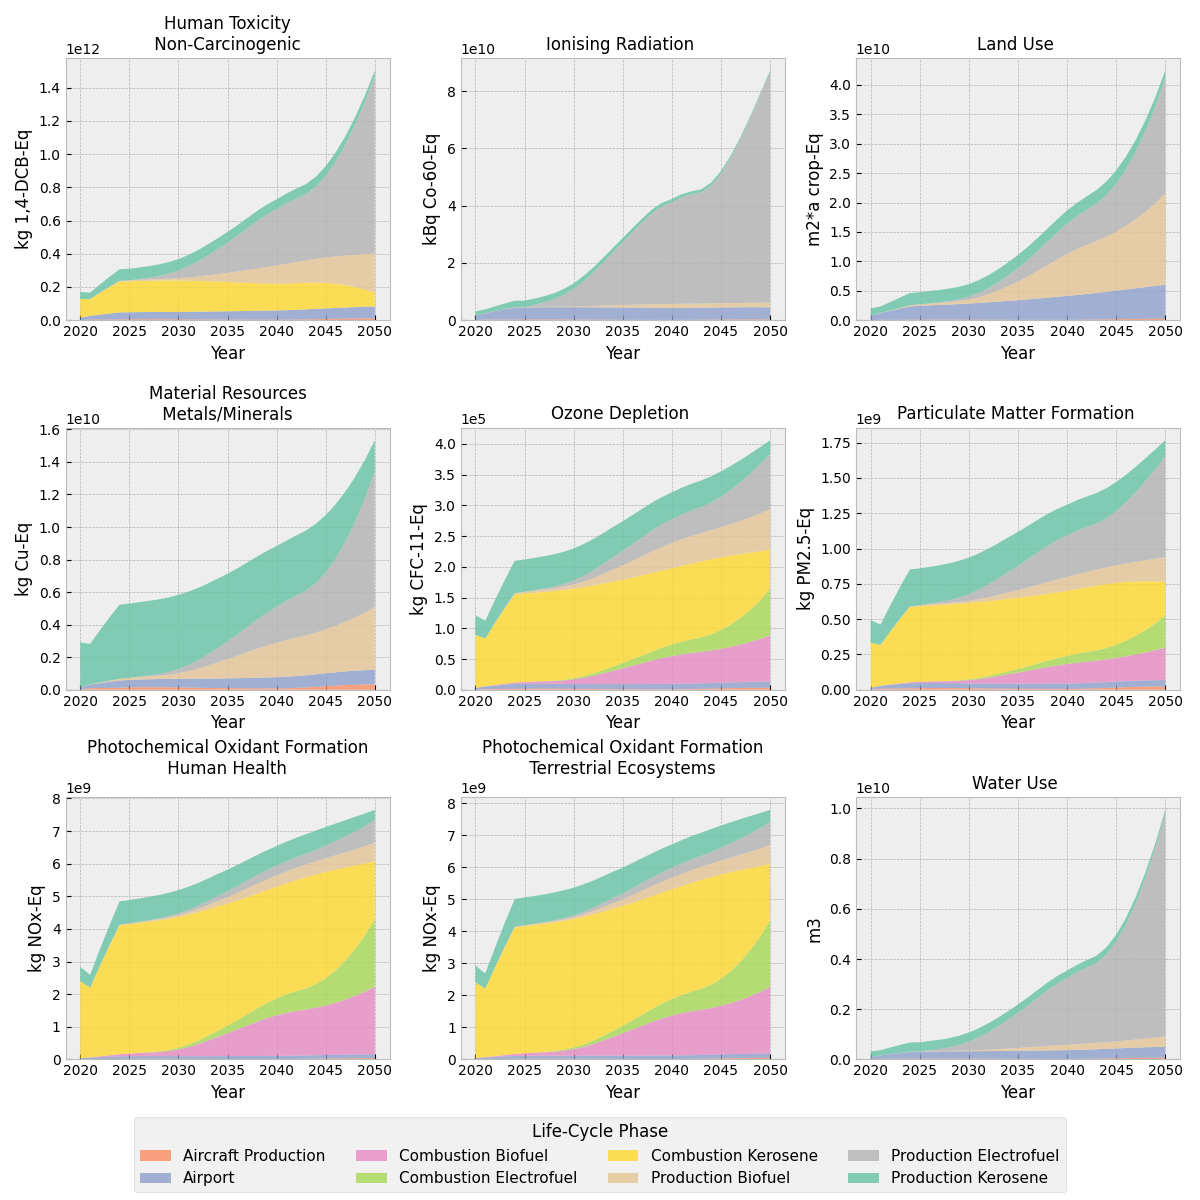

In [29]:
df_to_plot = lca_outputs_df_scenario_2[
    ~lca_outputs_df_scenario_2.index.get_level_values("method").str.contains("total")
]
# df_to_plot = lca_outputs_df_scenario_2[lca_outputs_df_scenario_2.index.get_level_values('method').str.contains('|'.join(['climate', 'land use', 'material']))]
plot_stacked_evolution_subplots(df_to_plot)
plt.savefig("lca_aeromaps_refueleu_midpoints_2.pdf")

## Scenario 3

In [30]:
# Set process
process = create_process(
    configuration_file="data/data_files/config.json",
    models=extended_models,
    use_fleet_model=True,
    add_examples_aircraft_and_subcategory=False,
)
set_aircraft_fleet(process)

## Share of alternative fuels in the drop-in fuel mix (the rest being supplemented by kerosene) [%]
process.parameters.biofuel_share_reference_years = [2020, 2025, 2030, 2035, 2040, 2045, 2050]
process.parameters.biofuel_share_reference_years_values = [0, 2, 4.8, 15, 24, 27, 35]
process.parameters.electrofuel_share_reference_years = [2020, 2025, 2030, 2035, 2040, 2045, 2050]
process.parameters.electrofuel_share_reference_years_values = [0, 0, 1.2, 5, 10, 15, 35]

# Share of photovoltaic in the electricity mix for efuel production
process.parameters.elec_solar_share_reference_years = [2020, 2030, 2040, 2050]
process.parameters.elec_solar_share_reference_years_values = [1.0, 1.0, 1.0, 1.0]

# Load factor of photovoltaic --> involves oversizing of electrolyzer and DAC capacities
process.parameters.load_factor_photovoltaic_reference_years = [
    2020,
    2025,
    2030,
    2035,
    2040,
    2045,
    2050,
]
process.parameters.load_factor_photovoltaic_reference_years_values = [
    0.14,
    0.14,
    0.14,
    0.14,
    0.14,
    0.14,
    0.14,
]

# Set water vapor to zero (FIXME?)
process.parameters.emission_index_h2o_kerosene = 0.0
process.parameters.emission_index_h2o_biofuel = 0.0
process.parameters.emission_index_h2o_electrofuel = 0.0

In [31]:
start_time = time.time()
process.compute()
print("--- %s seconds ---" % (time.time() - start_time))

--- 9.207051038742065 seconds ---


In [32]:
process_data_vector_outputs_scenario_3 = process.data["vector_outputs"]
process_data_fleet_model_df_scenario_3 = process.fleet_model.df
process_data_float_inputs_scenario_3 = process.data["float_inputs"]
lca_outputs_df_scenario_3 = process.lca_outputs_df
lca_outputs_df_scenario_3.T

method acidification: terrestrial - terrestrial acidification potential (TAP)[kg SO2-Eq]  \
phase                                                                            _other_   
2020                                                                                   0   
2021                                                                                   0   
2022                                                                                   0   
2023                                                                                   0   
2024                                                                                   0   
2025                                                                                   0   
2026                                                                                   0   
2027                                                                                   0   
2028                                                                                   0   
2029                                                                                   0   
2030                                                                                   0   
2031                                                                                   0   
2032                                                                                   0   
2033                                                                                   0   
2034                                                                                   0   
2035                                                                                   0   
2036                                                                                   0   
2037                                                                                   0   
2038                                                                                   0   
2039                                                                                   0   
2040                                                                                   0   
2041                                                                                   0   
2042                                                                                   0   
2043                                                                                   0   
2044                                                                                   0   
2045                                                                                   0   
2046                                                                                   0   
2047                                                                                   0   
2048                                                                                   0   
2049                                                                                   0   
2050                                                                                   0   

method                                                     \
phase  aircraft_production     airport combustion_biofuel   
2020                     0  3.8357e+07                  0   
2021           2.19327e+07 5.53719e+07        3.42595e+06   
2022           2.45146e+07 7.13417e+07        8.71058e+06   
2023           2.65878e+07 8.62662e+07        1.55671e+07   
2024            2.7884e+07 1.00146e+08        2.37184e+07   
2025           3.23301e+07 9.98876e+07         2.9097e+07   
2026           3.51766e+07  9.9524e+07        3.42396e+07   
2027           3.53647e+07 9.90488e+07        3.91636e+07   
2028           3.45709e+07 9.84554e+07        4.47046e+07   
2029            3.3017e+07 9.77373e+07        5.58319e+07   
2030           3.09242e+07 9.68875e+07        7.36433e+07   
2031           2.87225e+07 9.82748e+07        9.85136e+07   
2032           2.65172e+07  9.9658e+07        1.30892e+08   
2033           2.44638e+07 1.01036e+08        1.

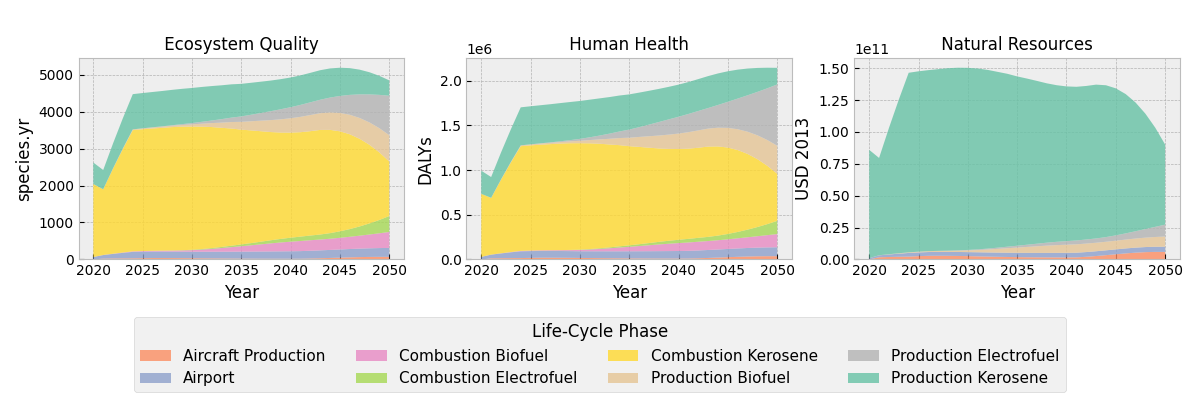

In [38]:
df_to_plot = lca_outputs_df_scenario_3[
    lca_outputs_df_scenario_3.index.get_level_values("method").str.contains("total")
]
# df_to_plot = lca_outputs_df_scenario_3[lca_outputs_df_scenario_3.index.get_level_values('method').str.contains('|'.join(['climate', 'land use', 'material']))]
plot_stacked_evolution_subplots(df_to_plot)
plt.savefig("lca_aeromaps_refueleu_fullsolar_loadfactor14percent_endpoints.pdf")

# Post-processing - Sensitivity Analysis

In [53]:
year = 2050
elec_solar_share = np.linspace(start=0, stop=1.0, num=31)

params_dict = dict(
    model="remind",
    pathway="SSP2_Base",
    rpk_long_range=process_data_vector_outputs_scenario_2["rpk_long_range"][year],
    rpk_medium_range=process_data_vector_outputs_scenario_2["rpk_medium_range"][year],
    rpk_short_range=process_data_vector_outputs_scenario_2["rpk_short_range"][year],
    aircraft_production_long_range=process_data_fleet_model_df_scenario_2[
        "Long Range: Aircraft Production"
    ][year],
    aircraft_production_medium_range=process_data_fleet_model_df_scenario_2[
        "Medium Range: Aircraft Production"
    ][year],
    aircraft_production_short_range=process_data_fleet_model_df_scenario_2[
        "Short Range: Aircraft Production"
    ][year],
    energy_consumption_kerosene=process_data_vector_outputs_scenario_2[
        "energy_consumption_kerosene"
    ][year],
    energy_consumption_biofuel=process_data_vector_outputs_scenario_2["energy_consumption_biofuel"][
        year
    ],
    energy_consumption_electrofuel=process_data_vector_outputs_scenario_2[
        "energy_consumption_electrofuel"
    ][year],
    lhv_kerosene=process_data_float_inputs_scenario_2["lhv_kerosene"],
    lhv_biofuel=process_data_float_inputs_scenario_2["lhv_biofuel"],
    lhv_electrofuel=process_data_float_inputs_scenario_2["lhv_electrofuel"],
    emission_index_nox_kerosene=process_data_vector_outputs_scenario_2[
        "emission_index_nox_kerosene"
    ][year],
    emission_index_sulfur_kerosene=process_data_float_inputs_scenario_2[
        "emission_index_sulfur_kerosene"
    ],
    emission_index_h2o_kerosene=process_data_float_inputs_scenario_2["emission_index_h2o_kerosene"],
    emission_index_soot_kerosene=process_data_vector_outputs_scenario_2[
        "emission_index_soot_kerosene"
    ][year],
    emission_index_nox_biofuel=process_data_vector_outputs_scenario_2["emission_index_nox_biofuel"][
        year
    ],
    emission_index_sulfur_biofuel=process_data_float_inputs_scenario_2[
        "emission_index_sulfur_biofuel"
    ],
    emission_index_h2o_biofuel=process_data_float_inputs_scenario_2["emission_index_h2o_biofuel"],
    emission_index_soot_biofuel=process_data_vector_outputs_scenario_2[
        "emission_index_soot_biofuel"
    ][year],
    emission_index_nox_electrofuel=process_data_vector_outputs_scenario_2[
        "emission_index_nox_electrofuel"
    ][year],
    emission_index_sulfur_electrofuel=process_data_float_inputs_scenario_2[
        "emission_index_sulfur_electrofuel"
    ],
    emission_index_h2o_electrofuel=process_data_float_inputs_scenario_2[
        "emission_index_h2o_electrofuel"
    ],
    emission_index_soot_electrofuel=process_data_vector_outputs_scenario_2[
        "emission_index_soot_electrofuel"
    ][year],
    load_factor_photovoltaic=0.14,
    elec_solar_share=elec_solar_share,
    year=year,
)

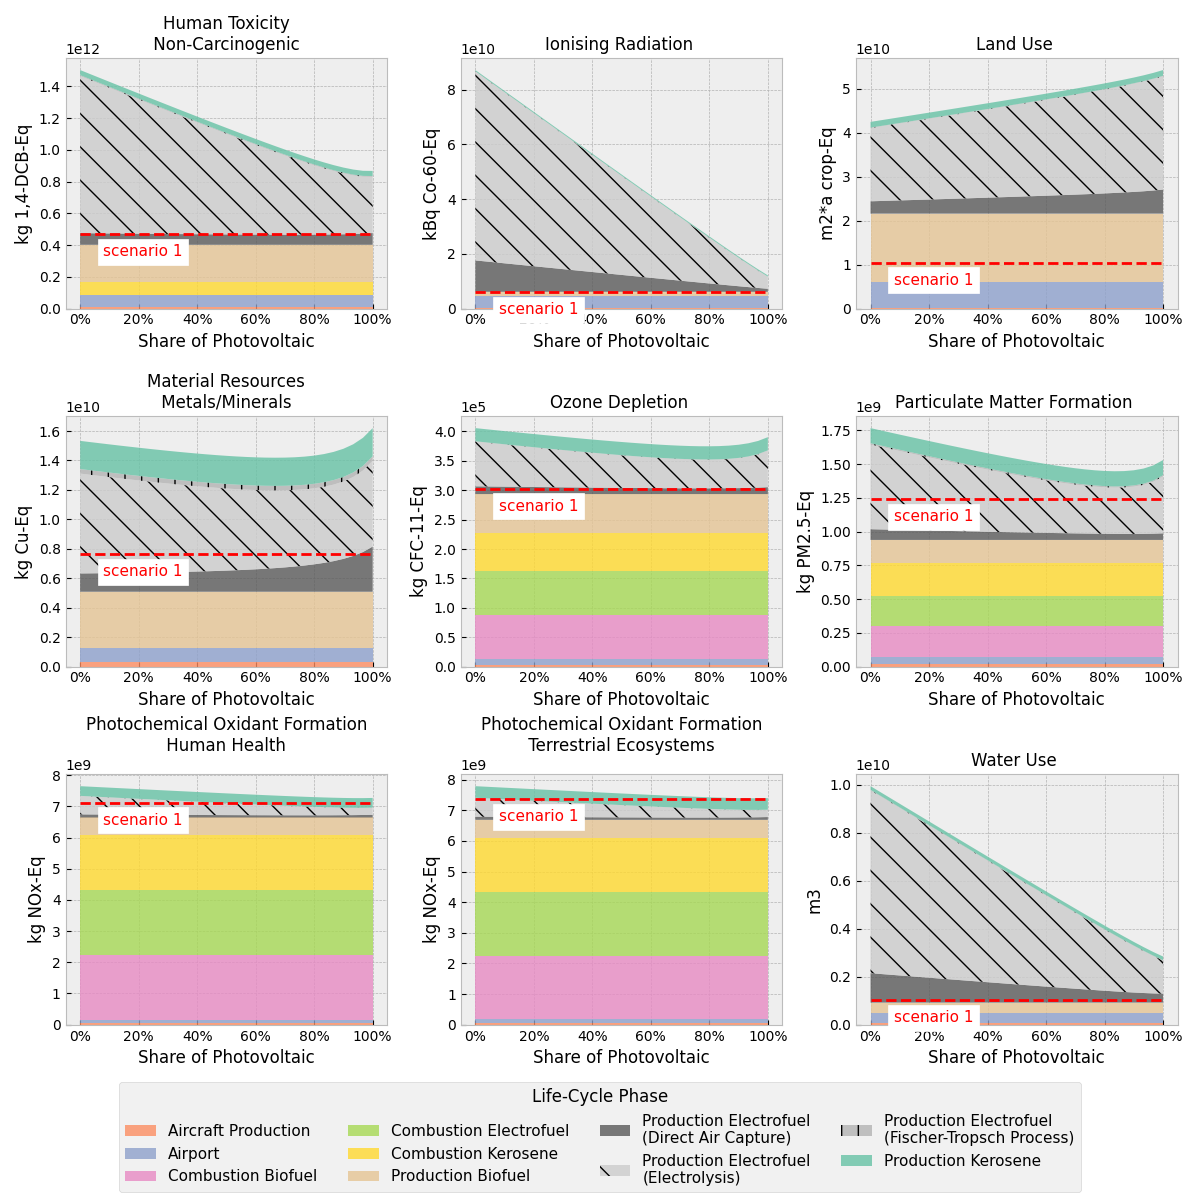

In [64]:
plt.close()

kerosene_scenario_values = {
    "acidification: terrestrial - terrestrial acidification potential (TAP)[kg SO2-Eq]": 3.9042e09,
    "climate change - global warming potential (GWP100)[kg CO2-Eq]": 1.66647e12,
    "ecotoxicity: freshwater - freshwater ecotoxicity potential (FETP)[kg 1,4-DCB-Eq]": 1.1378e10,
    "ecotoxicity: marine - marine ecotoxicity potential (METP)[kg 1,4-DCB-Eq]": 1.72581e10,
    "ecotoxicity: terrestrial - terrestrial ecotoxicity potential (TETP)[kg 1,4-DCB-Eq]": 4.24346e12,
    "energy resources: non-renewable, fossil - fossil fuel potential (FFP)[kg oil-Eq]": 4.92981e11,
    "eutrophication: freshwater - freshwater eutrophication potential (FEP)[kg P-Eq]": 3.07215e07,
    "eutrophication: marine - marine eutrophication potential (MEP)[kg N-Eq]": 3.33666e07,
    "human toxicity: carcinogenic - human toxicity potential (HTPc)[kg 1,4-DCB-Eq]": 2.13437e10,
    "human toxicity: non-carcinogenic - human toxicity potential (HTPnc)[kg 1,4-DCB-Eq]": 4.68682e11,
    "ionising radiation - ionising radiation potential (IRP)[kBq Co-60-Eq]": 5.8845e09,
    "land use - agricultural land occupation (LOP)[m2*a crop-Eq]": 1.03583e10,
    "material resources: metals/minerals - surplus ore potential (SOP)[kg Cu-Eq]": 7.61435e09,
    "ozone depletion - ozone depletion potential (ODPinfinite)[kg CFC-11-Eq]": 302500,
    "particulate matter formation - particulate matter formation potential (PMFP)[kg PM2.5-Eq]": 1.24096e09,
    "photochemical oxidant formation: human health - photochemical oxidant formation potential: humans (HOFP)[kg NOx-Eq]": 7.1164e09,
    "photochemical oxidant formation: terrestrial ecosystems - photochemical oxidant formation potential: ecosystems (EOFP)[kg NOx-Eq]": 7.36927e09,
    "water use - water consumption potential (WCP)[m3]": 1.01181e09,
    "total: ecosystem quality - ecosystem quality[species.yr]": 6615.89,
    "total: human health - human health[DALYs]": 2.51311e06,
    "total: natural resources - natural resources[USD 2013]": 2.1932e11,
}


def plot_stacked_sensitivity_subplots(df):
    # Remove phases containing 'sum'
    df_filtered = df[~df.index.get_level_values("phase").str.contains("sum")]

    methods = df_filtered.index.get_level_values("method").unique()[9:]
    years = df_filtered.columns

    # Determine the number of rows and columns for the subplots
    n_methods = len(methods)
    n_cols = 3  # 2 if n_methods % 2 == 0 else 3
    n_rows = math.ceil(n_methods / n_cols)

    # Use seaborn color palette for better aesthetics
    palette = sns.color_palette("Set2", len(df_filtered.index.levels[1]))
    palette_dict = {
        "aircraft_production": (palette[1], ""),
        "airport": (palette[2], ""),
        "combustion_biofuel": (palette[3], ""),
        "combustion_electrofuel": (palette[4], ""),
        "combustion_kerosene": (palette[5], ""),
        "production_biofuel": (palette[6], ""),
        "production_electrofuel": (palette[7], ""),
        "Production Electrofuel\n(Fischer-Tropsch process)": (palette[7], "|"),
        "Production Electrofuel\n(Direct Air Capture)": ("0.35", ""),
        "Production Electrofuel\n(Electrolysis)": ("0.8", "\\"),
        "production_kerosene": (palette[8], ""),
    }

    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 4), constrained_layout=False)
    axes = axes.flatten()  # Flatten the array of axes for easy iteration

    for i, method in enumerate(methods):
        df_method = df_filtered.xs(method, level="method")
        df_method.index = df_method.index.str.replace(
            "_other_", "Production Electrofuel\n(Fischer-Tropsch process)"
        )
        df_method.index = df_method.index.str.replace(
            "production_electrofuel_DAC", "Production Electrofuel\n(Direct Air Capture)"
        )
        df_method.index = df_method.index.str.replace(
            "production_electrofuel_electrolysis", "Production Electrofuel\n(Electrolysis)"
        )

        # Rearrange columns order for plot order
        cols = df_method.index.tolist()
        cols = cols[1:-1] + cols[:1] + cols[-1:]
        df_method = df_method.reindex(index=cols)

        # Plot stacked area chart with custom colors
        stacks = axes[i].stackplot(
            years,
            df_method,
            labels=df_method.index,
            alpha=0.8,
            colors=[palette_dict[key][0] for key in df_method.index],
        )

        # Add reference line of kerosene scenario
        axes[i].hlines(
            y=kerosene_scenario_values[method], xmin=0, xmax=1, linewidth=2, color="r", ls="--"
        )
        axes[i].annotate(
            "scenario 1",
            (0.28, kerosene_scenario_values[method]),
            xycoords="data",
            xytext=(15, -18),
            textcoords="offset points",
            fontsize=11,
            va="bottom",
            ha="right",
            color="red",
            backgroundcolor="w",
        )

        # Customize the subplot
        name, unit = method.split("[", 1)
        # name = name.replace('- ', '\n').replace('(', '\n(')
        name = name.replace("total", "")
        name = name.split("- ")[0]
        name = name.replace(":", "\n")
        name = "".join([a if a.isupper() else b for a, b in zip(name, name.title())])
        unit = unit.replace("]", "")
        axes[i].set_title(name, fontsize=12)
        axes[i].set_xlabel("Share of Photovoltaic")
        axes[i].set_ylabel(unit)
        axes[i].grid(True)
        axes[i].set_axisbelow(True)
        axes[i].ticklabel_format(axis="y", scilimits=(0, 4))
        axes[i].xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        # if i == 0 or i == len(axes) - 1:
        # axes[i].legend()

        hatches = [palette_dict[key][1] for key in df_method.index]
        for stack, hatch in zip(stacks, hatches):
            if hatch:
                stack.set_hatch(hatch)

    # Remove any empty subplots
    # for j in range(i + 1, len(axes)):
    #    fig.delaxes(axes[j])

    # Add a single legend for all subplots
    # handles, labels = axes[0].get_legend_handles_labels()
    # fig.legend(handles, labels, title='Phase', loc='lower center', ncol=4, bbox_to_anchor = (0, -0.01, 1, 1))#, mode="expand") #, ncol=len(df_filtered.index.levels[1]))
    # plt.tight_layout()

    # Collect legend labels from all plots.
    entries = collections.OrderedDict()
    for ax in axes.flatten():
        for handle, label in zip(*axes[0].get_legend_handles_labels()):
            # if 'biofuel' in label or 'electrofuel' in label:
            #    continue
            label_name = label.replace("_", " ").title()
            entries[label_name] = handle
    legend = fig.legend(
        entries.values(),
        entries.keys(),
        loc="lower center",
        bbox_to_anchor=(0.5, 0),
        ncol=4,
        fontsize=11,
        title="Life-Cycle Phase",
        title_fontsize=12,
    )

    # Set tight layout while keeping legend in the screen
    bbox = legend.get_window_extent(fig.canvas.get_renderer()).transformed(
        fig.transFigure.inverted()
    )
    fig.tight_layout(rect=(0, bbox.y1, 1, 1), h_pad=0.5, w_pad=0.5)

    # show plot
    plt.show()


# LCIA calculation
multi_df_lca = (
    pd.DataFrame()
)  # Create empty DataFrame to store the results for each impact method and year

# Calculate impacts for each year
# FIXME: this is a temporary solution waiting for lca_algebraic to handle 'axis' and multi params simultaneously
parameters_tmp = params_dict.copy()
for i, elec_solar_share_value in enumerate(params_dict["elec_solar_share"]):
    # Get the value of each parameter for the current year
    for key, val in params_dict.items():
        if isinstance(val, (list, np.ndarray)):
            parameters_tmp[key] = val[i]

    res = process.models["life_cycle_assessment"].compute_impacts_from_lambdas(**parameters_tmp)

    # Build MultiIndex DataFrame by iterating over each method
    df_year = pd.DataFrame()  # DataFrame for the results of each impact method for the current year
    for method in res.columns:
        # Extract the results for the current method
        data = res[method]
        # Create a DataFrame with MultiIndex consisting of method and year
        df_year_method = pd.DataFrame(
            data.values,
            columns=[elec_solar_share_value],
            index=pd.MultiIndex.from_product([[method], data.index], names=["method", "phase"]),
        )
        # Concatenate the new DataFrame with the existing DataFrame
        df_year = pd.concat([df_year, df_year_method], axis=0)

    # Concatenate the DataFrame with the final LCA DataFrame
    multi_df_lca = pd.concat([multi_df_lca, df_year], axis=1)

# Call the function
df_to_plot = multi_df_lca[~multi_df_lca.index.get_level_values("method").str.contains("total")]
# df_to_plot = multi_df_lca[multi_df_lca.index.get_level_values('method').str.contains('|'.join(['climate', 'land use', 'material']))]
plot_stacked_sensitivity_subplots(df_to_plot)
plt.savefig("lca_aeromaps_refueleu_sensitivity_midpoints_2.pdf")

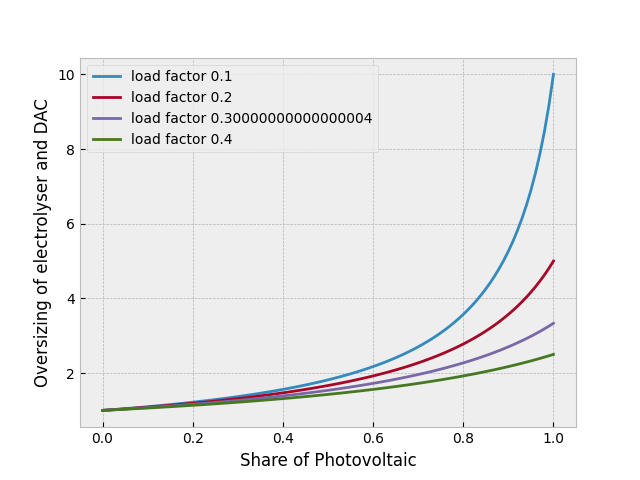

In [61]:
# Visualize evolution of oversizing factor on electrofuel facilities to better understand why we have an optimum on some categories
fig, ax = plt.subplots()
load_factor_test = np.arange(0.1, 0.5, 0.1)
x_test = np.arange(0.0, 1.01, 0.01)
for factor in load_factor_test:
    y_test = 1 / (1.0 - (1.0 - factor) * x_test)
    ax.plot(x_test, y_test, label=f"load factor {factor}")
ax.set_xlabel("Share of Photovoltaic")
ax.set_ylabel("Oversizing of electrolyser and DAC")
ax.legend()

# Postprocessing - From midpoints to endpoints

In [65]:
methods = [
    m for m in agb.findMethods("", mainCat="ReCiPe 2016 v1.03, endpoint (H)") if "total" not in m[1]
]
methods_ecosystem = [m for m in methods if "ecosystem quality" in m[1]]
methods_human_health = [m for m in methods if "human health" in m[1]]
methods_resources = [m for m in methods if "natural resources" in m[1]]

In [66]:
# Create function to get the data for each scenario
def get_scenario_data(scenario, year, elec_solar_share):
    scenario_data_vector = globals()[f"process_data_vector_outputs_scenario_{scenario}"]
    scenario_data_fleet = globals()[f"process_data_fleet_model_df_scenario_{scenario}"]
    scenario_data_float = globals()[f"process_data_float_inputs_scenario_{scenario}"]

    return dict(
        model="remind",
        pathway="SSP2_Base",
        rpk_long_range=scenario_data_vector["rpk_long_range"][year],
        rpk_medium_range=scenario_data_vector["rpk_medium_range"][year],
        rpk_short_range=scenario_data_vector["rpk_short_range"][year],
        aircraft_production_long_range=scenario_data_fleet["Long Range: Aircraft Production"][year],
        aircraft_production_medium_range=scenario_data_fleet["Medium Range: Aircraft Production"][
            year
        ],
        aircraft_production_short_range=scenario_data_fleet["Short Range: Aircraft Production"][
            year
        ],
        energy_consumption_kerosene=scenario_data_vector["energy_consumption_kerosene"][year],
        energy_consumption_biofuel=scenario_data_vector["energy_consumption_biofuel"][year],
        energy_consumption_electrofuel=scenario_data_vector["energy_consumption_electrofuel"][year],
        lhv_kerosene=scenario_data_float["lhv_kerosene"],
        lhv_biofuel=scenario_data_float["lhv_biofuel"],
        lhv_electrofuel=scenario_data_float["lhv_electrofuel"],
        emission_index_nox_kerosene=scenario_data_vector["emission_index_nox_kerosene"][year],
        emission_index_sulfur_kerosene=scenario_data_float["emission_index_sulfur_kerosene"],
        emission_index_h2o_kerosene=scenario_data_float["emission_index_h2o_kerosene"],
        emission_index_soot_kerosene=scenario_data_vector["emission_index_soot_kerosene"][year],
        emission_index_nox_biofuel=scenario_data_vector["emission_index_nox_biofuel"][year],
        emission_index_sulfur_biofuel=scenario_data_float["emission_index_sulfur_biofuel"],
        emission_index_h2o_biofuel=scenario_data_float["emission_index_h2o_biofuel"],
        emission_index_soot_biofuel=scenario_data_vector["emission_index_soot_biofuel"][year],
        emission_index_nox_electrofuel=scenario_data_vector["emission_index_nox_electrofuel"][year],
        emission_index_sulfur_electrofuel=scenario_data_float["emission_index_sulfur_electrofuel"],
        emission_index_h2o_electrofuel=scenario_data_float["emission_index_h2o_electrofuel"],
        emission_index_soot_electrofuel=scenario_data_vector["emission_index_soot_electrofuel"][
            year
        ],
        load_factor_photovoltaic=0.14,
        elec_solar_share=elec_solar_share,
        year=year,
    )

In [71]:
year = 2050
methods = [methods_ecosystem, methods_human_health, methods_resources]
method_names = ["Ecosystem Quality", "Human Health", "Natural Resources"]
scenario_numbers = [1, 2, 3]
elec_solar_shares = [0.0, 0.0, 1.0]

# Initialize dictionaries to hold dataframes for each method
dfs = {}

for method, method_name in zip(methods, method_names):
    df = pd.DataFrame()
    for scenario, elec_solar_share in zip(scenario_numbers, elec_solar_shares):
        params_dict = get_scenario_data(scenario, year, elec_solar_share)

        res = agb.compute_impacts(
            process.models["life_cycle_assessment"].model, method, **params_dict
        )

        # Rename the index for the current result
        res = res.rename(index={"model": f"scenario {scenario}"})

        # Concatenate the result to the DataFrame
        df = pd.concat([df, res], axis=0, ignore_index=False)

    # Normalize by the values of scenario 1
    scenario_1_values = df.loc[df.index == "scenario 1"]
    df = df.divide(scenario_1_values.values.sum())

    # Store the dataframe in the dictionary
    dfs[method_name] = df

In [72]:
# for method_name in method_names:
#    dfs[method_name].to_excel(f'endpoints_contributions_{method_name}.xlsx')

In [73]:
dfs = {
    method_name: pd.read_excel(f"endpoints_contributions_{method_name}.xlsx", index_col=0)
    for method_name in method_names
}
combined_df = pd.concat(dfs, names=["Method", "Scenario"])  # .reset_index()#(level=0)
combined_df

Terrestrial Acidification  Climate Change  \
Method            Scenario                                                
Ecosystem Quality scenario 1                   0.124831        0.703976   
                  scenario 2                   0.172488        0.449641   
                  scenario 3                   0.149834        0.328439   
Human Health      scenario 1                        NaN        0.615353   
                  scenario 2                        NaN        0.393037   
                  scenario 3                        NaN        0.287093   
Natural Resources scenario 1                        NaN             NaN   
                  scenario 2                        NaN             NaN   
                  scenario 3                        NaN             NaN   

                              Land Use  Photochemical Oxidant Formation  \
Method            Scenario                                                
Ecosystem Quality scenario 1  0.013866                         0.143392   
                  scenario 2 0.0567923                         0.151553   
                  scenario 3 0.0725676                         0.143976   
Human Health      scenario 1       NaN                              NaN   
                  scenario 2       NaN                              NaN   
                  scenario 3       NaN                              NaN   
Natural Resources scenario 1       NaN                              NaN   
                  scenario 2       NaN                              NaN   
                  scenario 3       NaN                              NaN   

                                 Others  Human Toxicity (Carcinogenic)  \
Method            Scenario                                               
Ecosystem Quality scenario 1  0.0139348                            NaN   
                  scenario 2  0.0855717                            NaN   
                  scenario 3  0.0415718                            NaN   
Human Health      scenario 1 0.00355473                      0.0281961   
                  scenario 2  0.0119313                      0.0992576   
                  scenario 3 0.00526449                      0.0994675   
Natural Resources scenario 1        NaN                            NaN   
                  scenario 2        NaN                            NaN   
                  scenario 3        NaN                            NaN   

                              Human Toxicity (Non-Carcinogenic)  \
Method            Scenario                                        
Ecosystem Quality scenario 1                                NaN   
                  scenario 2                                NaN   
                  scenario 3                                NaN   
Human Health      scenario 1                          0.0425078   
                  scenario 2                            0.13639   
                  scenario 3                          0.0786849   
Natural Resources scenario 1                                NaN   
                  scenario 2                                NaN   
                  scenario 3                                NaN   

                              Particulate Matter Formation  \
Method            Scenario                                   
Ecosystem Quality scenario 1                           NaN   
                  scenario 2                           NaN   
                  scenario 3                           NaN   
Human Health      scenario 1                      0.310388   
                  scenario 2                      0.441654   
                  scenario 3                      0.382571   
Natural Resources scenario 1                           NaN   
                  scenario 2                           NaN   
                  scenario 3                           NaN   

                              Energy Resources (Fossil)  \
Method            Scenario                                
Ecosystem Quality scenar

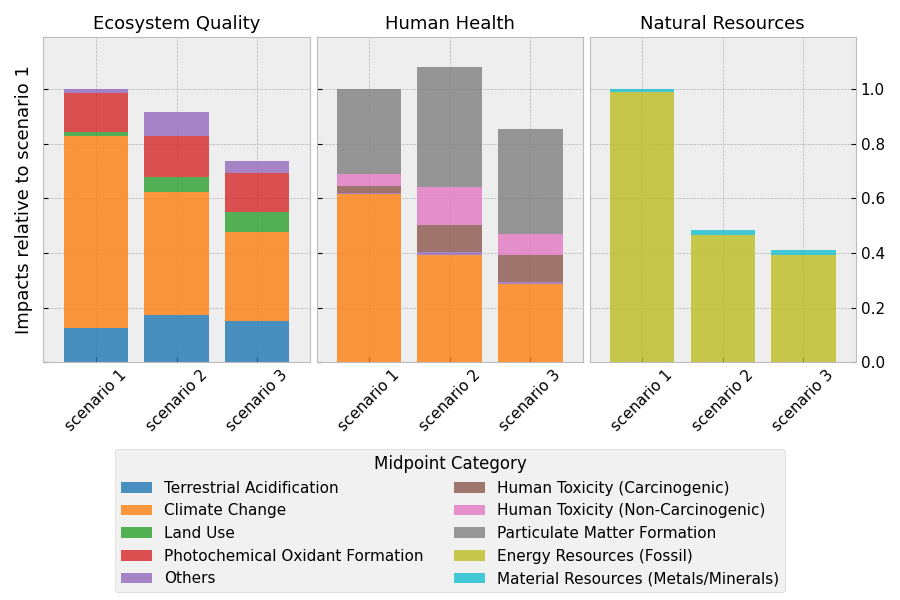

In [75]:
# from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec

clusters = combined_df.index.levels[0]
inter_graph = 0
maxi = np.max(np.sum(combined_df, axis=1))
total_width = len(combined_df) + inter_graph * (len(clusters) - 1)

fig = plt.figure(figsize=(total_width, 6))
gridspec.GridSpec(1, total_width)
axes = []
palette = sns.color_palette("tab10")

ax_position = 0
for cluster in clusters:
    subset = combined_df.loc[cluster]
    ax = subset.plot(
        kind="bar",
        stacked=True,
        width=0.8,
        ax=plt.subplot2grid((1, total_width), (0, ax_position), colspan=len(subset.index)),
        color=palette,
        alpha=0.8,
    )
    axes.append(ax)
    ax.set_title(cluster, fontsize=13)
    ax.set_xlabel("")
    ax.set_ylim(0, maxi * 1.1)
    # ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax_position += len(subset.index) + inter_graph
    ax.tick_params(axis="x", rotation=45, labelsize=11)
    ax.set_axisbelow(True)

for i in range(0, len(clusters)):
    axes[i].legend().set_visible(False)
for i in range(0, len(clusters) - 1):
    axes[i].set_yticklabels("")
axes[-1].yaxis.tick_right()
axes[-1].tick_params(axis="y", labelsize=11)
axes[0].set_ylabel("Impacts relative to scenario 1", fontsize=13)

# Collect legend labels from all plots.
entries = collections.OrderedDict()
for ax in axes:
    for handle, label in zip(*axes[0].get_legend_handles_labels()):
        label_name = label.replace("_", " ").title()
        entries[label_name] = handle
legend = fig.legend(
    entries.values(),
    entries.keys(),
    loc="lower center",
    bbox_to_anchor=(0.5, 0),
    ncol=2,
    fontsize=11,
    title="Midpoint Category",
    title_fontsize=12,
)

# Set tight layout while keeping legend in the screen
bbox = legend.get_window_extent(fig.canvas.get_renderer()).transformed(fig.transFigure.inverted())
fig.tight_layout(rect=(0, bbox.y1, 1, 1), h_pad=0.5, w_pad=0.5)

plt.show()
plt.savefig("endpoints_contributions.pdf")

# IAMs comparison

On scenario 2 (ReFuelEU with grid electricity for electrofuels production).

In [13]:
## Run AeroMAPS scenario

# Set process
process = create_process(
    configuration_file="data/data_files/config.json",
    models=extended_models,
    use_fleet_model=True,
    add_examples_aircraft_and_subcategory=False,
)
set_aircraft_fleet(process)

## Share of alternative fuels in the drop-in fuel mix (the rest being supplemented by kerosene) [%]
process.parameters.biofuel_share_reference_years = [2020, 2025, 2030, 2035, 2040, 2045, 2050]
process.parameters.biofuel_share_reference_years_values = [0, 2, 4.8, 15, 24, 27, 35]
process.parameters.electrofuel_share_reference_years = [2020, 2025, 2030, 2035, 2040, 2045, 2050]
process.parameters.electrofuel_share_reference_years_values = [0, 0, 1.2, 5, 10, 15, 35]

# Share of photovoltaic in the electricity mix for efuel production
process.parameters.elec_solar_share_reference_years = [2020, 2030, 2040, 2050]
process.parameters.elec_solar_share_reference_years_values = [0.0, 0.0, 0.0, 0.0]

# Set water vapor to zero (FIXME?)
process.parameters.emission_index_h2o_kerosene = 0.0
process.parameters.emission_index_h2o_biofuel = 0.0
process.parameters.emission_index_h2o_electrofuel = 0.0

In [ ]:
# REMIND - SSP2 Base

# NB: to be modified soon (--> single value instead of a list over years)
process.parameters.model_reference_years_values = ["remind"]  # this is the default IAM model
process.parameters.pathway_reference_years_values = [
    "SSP2_Base"
]  # this is the default IAM scenario

# Run process
start_time = time.time()
process.compute()
print("--- %s seconds ---" % (time.time() - start_time))

process.lca_outputs_df.to_excel("lca_outputs_scenario_2_remind_SSP2_base.xlsx")
process.lca_outputs_df.T

In [14]:
# IMAGE - SSP2 Base --> Change definition in configuration file and re-run notebook

# NB: to be modified soon (--> single value instead of a list over years)
process.parameters.model_reference_years_values = ["image"]  # this is the default IAM model
process.parameters.pathway_reference_years_values = [
    "SSP2_Base"
]  # this is the default IAM scenario

# Run process
start_time = time.time()
process.compute()
print("--- %s seconds ---" % (time.time() - start_time))

process.lca_outputs_df.to_excel("lca_outputs_scenario_2_image_SSP2_base.xlsx")
process.lca_outputs_df.T

--- 11.005815029144287 seconds ---


method acidification: terrestrial - terrestrial acidification potential (TAP)[kg SO2-Eq]  \
phase                                                                            _other_   
2020                                                                                   0   
2021                                                                                   0   
2022                                                                                   0   
2023                                                                                   0   
2024                                                                                   0   
2025                                                                                   0   
2026                                                                            37,143.8   
2027                                                                            86,708.2   
2028                                                                             152,352   
2029                                                                             255,405   
2030                                                                             400,300   
2031                                                                             592,498   
2032                                                                             833,102   
2033                                                                         1.12284e+06   
2034                                                                         1.44997e+06   
2035                                                                         1.80735e+06   
2036                                                                           2.207e+06   
2037                                                                         2.64621e+06   
2038                                                                         3.11683e+06   
2039                                                                         3.56242e+06   
2040                                                                         3.96981e+06   
2041                                                                         4.33647e+06   
2042                                                                         4.65598e+06   
2043                                                                         4.96692e+06   
2044                                                                         5.53002e+06   
2045                                                                         6.39664e+06   
2046                                                                         7.57417e+06   
2047                                                                         9.07053e+06   
2048                                                                         1.08966e+07   
2049                                                                         1.30689e+07   
2050                                                                         1.56108e+07   

method                                                     \
phase  aircraft_production     airport combustion_biofuel   
2020                     0 3.57141e+07                  0   
2021           2.24538e+07 5.25934e+07        3.42595e+06   
2022            2.5302e+07 6.91769e+07        8.71058e+06   
2023           2.76687e+07 8.54647e+07        1.55671e+07   
2024           2.92602e+07 1.01457e+08        2.37184e+07   
2025           3.42109e+07 1.03577e+08         2.9097e+07   
2026           3.75386e+07 1.05734e+08        3.42396e+07   
2027           3.80627e+07 1.07927e+08        3.91636e+07   
2028           3.75292e+07 1.10156e+08        4.47046e+07   
2029           3.61544e+07 1.12422e+08        5.58319e+07   
2030           3.41601e+07 1.14724e+08        7.36433e+07   
2031           3.18772e+07 1.18105e+08        9.85136e+07   
2032           2.95689e+07 1.21585e+08        1.30892e+08   
2033           2.74094e+07 1.25168e+08        1.

In [ ]:
# REMIND - SSP1 RCP2.6 (Peak budget 1150 GtCO2 - Paris Agreement)

# NB: to be modified soon (--> single value instead of a list over years)
process.parameters.model_reference_years_values = ["remind"]  # this is the default IAM model
process.parameters.pathway_reference_years_values = [
    "SSP1_PkBudg1150"
]  # this is the default IAM scenario

# Run process
start_time = time.time()
process.compute()
print("--- %s seconds ---" % (time.time() - start_time))

process.lca_outputs_df.to_excel("lca_outputs_scenario_2_remind_SSP1_PkBudg1150.xlsx")
process.lca_outputs_df.T

In [ ]:
# REMIND - SSP2 RCP2.6 (Peak budget 1150 GtCO2 - Paris Agreement)

# NB: to be modified soon (--> single value instead of a list over years)
process.parameters.model_reference_years_values = ["remind"]  # this is the default IAM model
process.parameters.pathway_reference_years_values = [
    "SSP2_PkBudg1150"
]  # this is the default IAM scenario

# Run process
start_time = time.time()
process.compute()
print("--- %s seconds ---" % (time.time() - start_time))

process.lca_outputs_df.to_excel("lca_outputs_scenario_2_remind_SSP2_PkBudg1150.xlsx")
process.lca_outputs_df.T

In [5]:
# IMAGE - SSP2 RCP2.6 (Peak budget 1150 GtCO2 - Paris Agreement)

# NB: to be modified soon (--> single value instead of a list over years)
process.parameters.model_reference_years_values = ["image"]  # this is the default IAM model
process.parameters.pathway_reference_years_values = [
    "SSP2_RCP26"
]  # this is the default IAM scenario

# Run process
start_time = time.time()
process.compute()
print("--- %s seconds ---" % (time.time() - start_time))

process.lca_outputs_df.to_excel("lca_outputs_scenario_2_image_SSP2_RCP26.xlsx")
process.lca_outputs_df.T

--- 10.920369148254395 seconds ---


method acidification: terrestrial - terrestrial acidification potential (TAP)[kg SO2-Eq]  \
phase                                                                            _other_   
2020                                                                                   0   
2021                                                                                   0   
2022                                                                                   0   
2023                                                                                   0   
2024                                                                                   0   
2025                                                                                   0   
2026                                                                            34,506.5   
2027                                                                            79,117.5   
2028                                                                             136,451   
2029                                                                             224,374   
2030                                                                             344,690   
2031                                                                             501,156   
2032                                                                             691,915   
2033                                                                             915,294   
2034                                                                         1.15958e+06   
2035                                                                         1.41738e+06   
2036                                                                         1.69646e+06   
2037                                                                         1.99272e+06   
2038                                                                         2.29822e+06   
2039                                                                         2.57066e+06   
2040                                                                         2.80183e+06   
2041                                                                         3.01858e+06   
2042                                                                         3.19571e+06   
2043                                                                         3.36068e+06   
2044                                                                         3.68755e+06   
2045                                                                         4.20261e+06   
2046                                                                         4.90163e+06   
2047                                                                         5.78035e+06   
2048                                                                           6.836e+06   
2049                                                                         8.06875e+06   
2050                                                                         9.48229e+06   

method                                                     \
phase  aircraft_production     airport combustion_biofuel   
2020                     0 3.57158e+07                  0   
2021           2.23746e+07 5.22678e+07        3.42595e+06   
2022           2.51216e+07 6.83098e+07        8.71058e+06   
2023           2.73713e+07 8.38418e+07        1.55671e+07   
2024           2.88393e+07 9.88636e+07        2.37184e+07   
2025           3.35946e+07 1.00237e+08         2.9097e+07   
2026            3.6726e+07 1.01605e+08        3.42396e+07   
2027           3.71002e+07 1.02964e+08        3.91636e+07   
2028           3.64438e+07 1.04313e+08        4.47046e+07   
2029           3.49772e+07 1.05651e+08        5.58319e+07   
2030           3.29235e+07 1.06974e+08        7.36433e+07   
2031           3.03392e+07 1.08337e+08        9.85136e+07   
2032           2.77861e+07 1.09685e+08        1.30892e+08   
2033           2.54264e+07 1.11017e+08        1.

In [15]:
# Import dataframes corresponding to each IAM model / SSP
lca_outputs_scenario_2_remind_SSP2_base = pd.read_excel(
    "lca_outputs_scenario_2_remind_SSP2_base.xlsx", index_col=[0, 1]
)
lca_outputs_scenario_2_image_SSP2_base = pd.read_excel(
    "lca_outputs_scenario_2_image_SSP2_base.xlsx", index_col=[0, 1]
)
lca_outputs_scenario_2_remind_SSP1_PkBudg1150 = pd.read_excel(
    "lca_outputs_scenario_2_remind_SSP1_PkBudg1150.xlsx", index_col=[0, 1]
)
lca_outputs_scenario_2_remind_SSP2_PkBudg1150 = pd.read_excel(
    "lca_outputs_scenario_2_remind_SSP2_PkBudg1150.xlsx", index_col=[0, 1]
)
lca_outputs_scenario_2_image_SSP2_RCP26 = pd.read_excel(
    "lca_outputs_scenario_2_image_SSP2_RCP26.xlsx", index_col=[0, 1]
)

In [66]:
iams = [
    lca_outputs_scenario_2_remind_SSP2_base,
    # lca_outputs_scenario_2_image_SSP2_base,
    lca_outputs_scenario_2_remind_SSP2_PkBudg1150,
    lca_outputs_scenario_2_remind_SSP1_PkBudg1150,
    # lca_outputs_scenario_2_image_SSP2_RCP26
]
iam_names = [
    "SSP2 - Baseline (No Climate Policy)",
    # "IMAGE - SSP2 Base",
    "SSP2 - RCP2.6",
    "SSP1 - RCP2.6",
    # "IMAGE - SSP2 RCP2.6",
]
dfs = {}

for df, name in zip(iams, iam_names):
    df_filtered = df[df.index.get_level_values("phase").str.contains("sum")]
    dfs[name] = df_filtered

combined_df = pd.concat(dfs, names=["IAM Model - Scenario"])  # .reset_index()#(level=0)
# combined_df.T

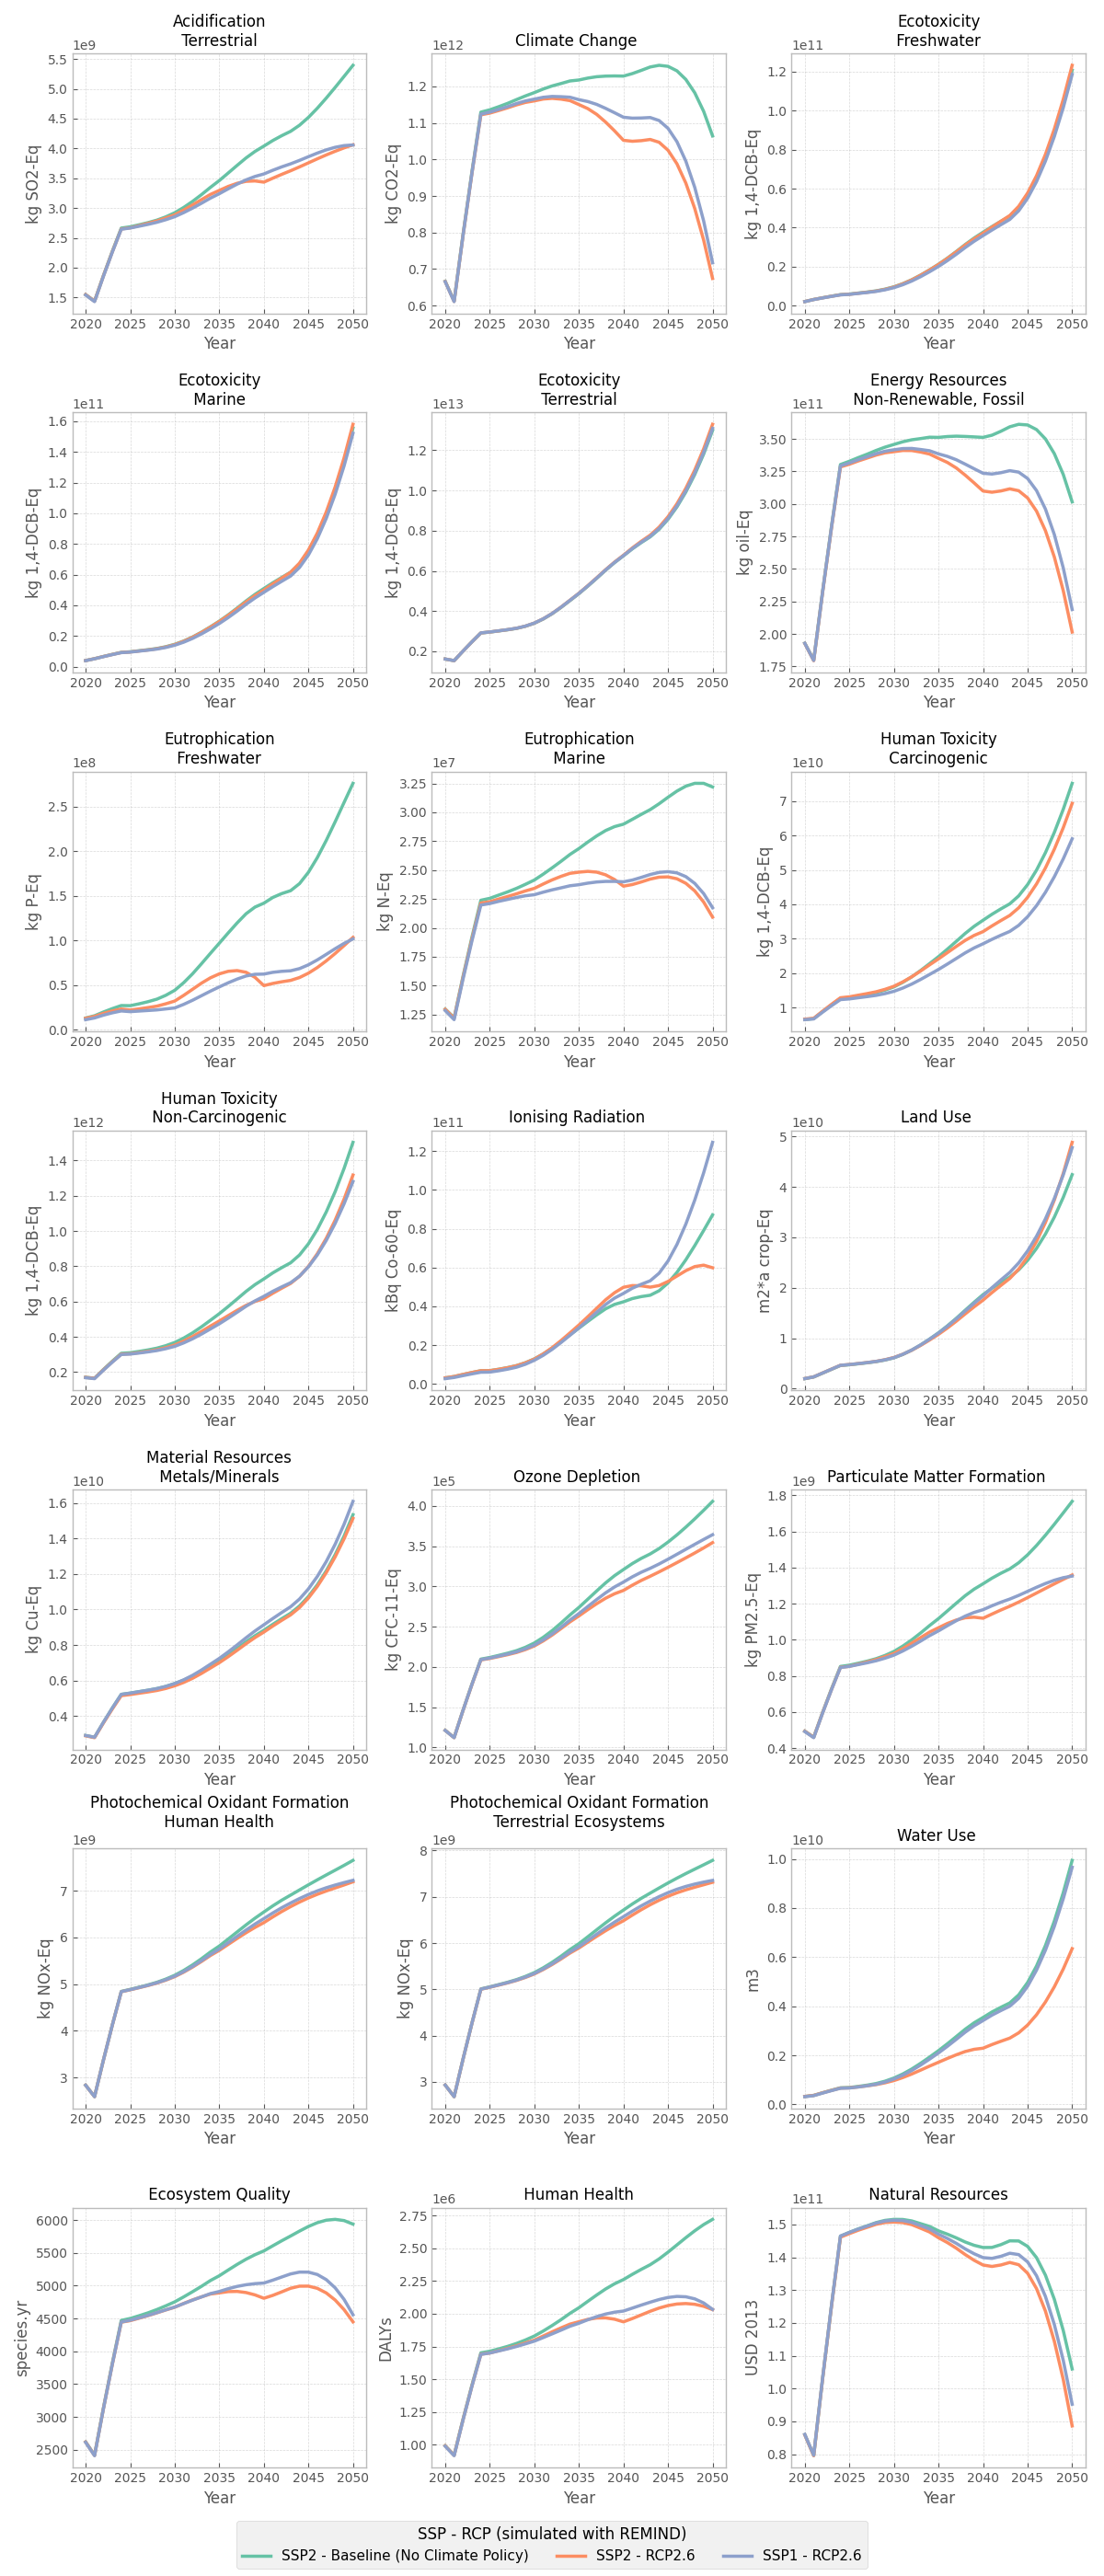

In [89]:
plt.style.use("bmh")


def plot_evolution_subplots_iams(df):
    iams = df.index.get_level_values("IAM Model - Scenario").unique()
    methods = df.index.get_level_values("method").unique()  # [-3:]#.take([1,11,12])
    # years = df.columns

    # Determine the number of rows and columns for the subplots
    n_methods = len(methods)
    n_cols = 3  # 2 if n_methods % 2 == 0 else 3
    n_rows = math.ceil(n_methods / n_cols)

    # Use seaborn color palette for better aesthetics
    palette = sns.color_palette("Set2", len(df.index.levels[1]))
    # palette = sns.color_palette("Paired", len(df_filtered.index.levels[1]))

    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 4), constrained_layout=False)
    axes = axes.flatten()  # Flatten the array of axes for easy iteration

    for k, iam in enumerate(iams):
        df_iam = df.xs(iam, level="IAM Model - Scenario")

        for i, method in enumerate(methods):
            df_method = df_iam.xs(method, level="method")

            # Plot stacked area chart with custom colors
            df_method.T["*sum*"].rename(iam).plot(
                ax=axes[i], label=iam, color=palette[k], linewidth=2.5
            )
            # axes[i].plot(years, df_method, alpha=0.8)

            # Customize the subplot
            name, unit = method.split("[", 1)
            # name = name.replace('- ', '\n').replace('(', '\n(')
            name = name.replace("total", "")
            name = name.split("- ")[0]
            name = name.replace(":", "\n")
            name = "".join([a if a.isupper() else b for a, b in zip(name, name.title())])
            unit = unit.replace("]", "")
            axes[i].set_title(name, fontsize=12)
            axes[i].set_xlabel("Year")
            axes[i].set_ylabel(unit)
            axes[i].grid(True, alpha=0.5)
            axes[i].set_axisbelow(True)
            axes[i].ticklabel_format(axis="y", scilimits=(0, 4))
            axes[i].set_facecolor("white")

    # Collect legend labels from all plots.
    entries = collections.OrderedDict()
    for ax in axes.flatten():
        for handle, label in zip(*axes[0].get_legend_handles_labels()):
            # if 'biofuel' in label or 'electrofuel' in label:
            #    continue
            label_name = label.replace("_", " ").replace("1150Gt", "RCP2.6")  # .title()
            entries[label_name] = handle
    legend = fig.legend(
        entries.values(),
        entries.keys(),
        loc="lower center",
        bbox_to_anchor=(0.5, 0),
        ncol=4,
        fontsize=11,
        title="SSP - RCP (simulated with REMIND)",
        title_fontsize=12,
    )

    # Set tight layout while keeping legend in the screen
    bbox = legend.get_window_extent(fig.canvas.get_renderer()).transformed(
        fig.transFigure.inverted()
    )
    fig.tight_layout(rect=(0, bbox.y1, 1, 1), h_pad=0.5, w_pad=0.5)

    # show plot
    plt.show()


plot_evolution_subplots_iams(combined_df)
# plt.savefig('lca_aeromaps_refueleu_ssp_rcp_endpoints.pdf')